# 1 Описание задачи

Миллионы людей ежедневно пользуются поиском по картинкам в Яндексе. 
Команда Яндекса прикладывает много усилий чтобы сделать сервис более полезным и удобным. 
Но для этого нужно хорошо понимать, какие задачи решают пользователи. К примеру, есть гипотеза, что интересы людей, ищущих картинки на мобильных устройствах и на десктопных компьютерах, заметно отличаются.
Вам нужно проверить эту гипотезу, сравнив запросы на разных платформах.

В файле data.json лежит выборка запросов к Яндекс Картинкам за несколько недель.
Каждый запрос описан словарем со следующими параметрами:
```
    query - текст запроса
    ts - timestamp запроса
    platform - платформа (touch - мобильный устройства, desktop - компьютеры)
```
Во время интервью Вам будет предложено ответить на ряд вопросов на основе имеющихся данных.

В ходе работы над задачей Вам будет разрешено использовать любые дополнительные материалы, поисковые системы и т.п.

**Примеры вопросов, которые могут быть заданы**
1. Выведите топ-10 самых частотных запросов в каждой платформе (desktop, touch). Какие отличия Вы видите?
2. Посмотрите, чем отличается трафик запросов в течение дня. Как можно объяснить отличие?
3. Выделите тематики запросов, контрастные для мобильных и компьютеров. Являются ли различия статистически значимыми?

# 2 Импорт библиотек

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from scipy.stats import mannwhitneyu, chi2_contingency
from nltk.corpus import stopwords
import pymorphy2
from collections import Counter

import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Настройки отображения
pd.set_option('display.max_colwidth', 120)
sns.set(style='whitegrid', palette='muted')

# 3 Чтение файла

In [3]:
# путь к файлу
path = 'D:\Yandex\data\data.json'

In [4]:
# чтение файла
df = pd.read_json(path, orient=None, typ='frame', precise_float=False, encoding=None, lines=False)

# 4 Первичный анализ данных

In [5]:
# общая информация о файле
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1203824 entries, 0 to 1203823
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   query     1203824 non-null  object
 1   ts        1203824 non-null  int64 
 2   platform  1203824 non-null  object
dtypes: int64(1), object(2)
memory usage: 27.6+ MB


In [6]:
# первые 10 страк файла
df.head(10)

,query,ts,platform
0,порно фото,1631786697,touch
1,малевич картины,1631806465,desktop
2,Секс,1631781583,touch
3,с днём рождения лена,1631771563,touch
4,зверополис порно,1631787599,touch
5,алабай собака фото,1631786645,touch
6,бактериофаг,1631816202,desktop
7,полина гагарина,1631804005,touch
8,кадр из фильма,1631770837,desktop
9,porno,1631780741,touch


In [7]:
# последние 10 строк файла
df.tail(10)

,query,ts,platform
1203814,владимир яковлев актер,1631459712,touch
1203815,ева элфи голая,1631444892,touch
1203816,с днём рождения женщине красивые,1631423584,touch
1203817,картинки с добрым утром,1631446722,touch
1203818,голые мужчины,1631396814,touch
1203819,бабочка,1631475653,touch
1203820,все республики россии,1631462934,touch
1203821,кухня в стиле лофт,1631432252,touch
1203822,топор,1631449347,desktop
1203823,аватарки для тик тока,1631457656,touch


In [8]:
# случайные 10 строк файла 
df.sample(10)

,query,ts,platform
936212,сочетание цветов в интерьере,1631979500,touch
203718,частная жизнь сериал,1631911074,touch
36815,флюорография,1631518504,touch
488096,рик и морти,1630500863,desktop
797713,таблица квадратов,1631716883,desktop
187453,фольксваген поло,1630605546,touch
131293,киа к5 2021,1630937983,touch
1049245,красивые голые девушки,1630517904,touch
1022479,дрочить,1632225914,desktop
130478,перманентный макияж губ,1631732793,touch


In [9]:
# проверка типов данных, datetime для ts
df.dtypes

query       object
ts           int64
platform    object
dtype: object

In [10]:
# проверка количества дубликатов
print("\nКоличество дубликатов:", df.duplicated().sum())


Количество дубликатов: 512


In [11]:
# наличие пропусков
print("\nПропуски:\n", df.isna().sum())


Пропуски:
 query       0
ts          0
platform    0
dtype: int64


# 5 Предобработка данных

## 5.1 Преобразование ts (timestamp → datetime)

Столбец "ts" содержит информацию о дате и времени в виде: "1631104272". Число вида 1631104272 — это Unix Timestamp. Оно представляет собой количество секунд, прошедших с полуночи (00:00:00 UTC) 1 января 1970 года. Конкретно это значение соответствует 8 сентября 2021 года.

Добавим в датафрем столбец "datetime" в котором преобразуем этот формат в панятную дату и время.

In [12]:
# Преобразуем timestamp в datetime
df['datetime'] = pd.to_datetime(df['ts'], unit='s')

In [13]:
df

,query,ts,platform,datetime
0,порно фото,1631786697,touch,2021-09-16 10:04:57
1,малевич картины,1631806465,desktop,2021-09-16 15:34:25
2,Секс,1631781583,touch,2021-09-16 08:39:43
3,с днём рождения лена,1631771563,touch,2021-09-16 05:52:43
4,зверополис порно,1631787599,touch,2021-09-16 10:19:59
...,...,...,...,...
1203819,бабочка,1631475653,touch,2021-09-12 19:40:53
1203820,все республики россии,1631462934,touch,2021-09-12 16:08:54
1203821,кухня в стиле лофт,1631432252,touch,2021-09-12 07:37:32
1203822,топор,1631449347,desktop,2021-09-12 12:22:27


## 5.2 Выделение дополнительных временных признаков

Для дополнительного анализа потребуется более детально посмотреть временной ряд датафрейма по часам и дням недели. Выделим эти значения в отдельные столбцы

In [14]:
df['hour'] = df['datetime'].dt.hour

In [15]:
df['dayofweek'] = df['datetime'].dt.day_name()

In [16]:
df

,query,ts,platform,datetime,hour,dayofweek
0,порно фото,1631786697,touch,2021-09-16 10:04:57,10,Thursday
1,малевич картины,1631806465,desktop,2021-09-16 15:34:25,15,Thursday
2,Секс,1631781583,touch,2021-09-16 08:39:43,8,Thursday
3,с днём рождения лена,1631771563,touch,2021-09-16 05:52:43,5,Thursday
4,зверополис порно,1631787599,touch,2021-09-16 10:19:59,10,Thursday
...,...,...,...,...,...,...
1203819,бабочка,1631475653,touch,2021-09-12 19:40:53,19,Sunday
1203820,все республики россии,1631462934,touch,2021-09-12 16:08:54,16,Sunday
1203821,кухня в стиле лофт,1631432252,touch,2021-09-12 07:37:32,7,Sunday
1203822,топор,1631449347,desktop,2021-09-12 12:22:27,12,Sunday


## 5.3 Очистка текстов запросов

В столбце 'query' содержатся текстовые запросы пользователей. Сделаем базовую очистку текста (препроцессинг), чтобы привести поисковые запросы к единому стандартному виду.

Что сделаем:
 - .str.lower() — переводит весь текст в нижний регистр (например, «Купить iPhone» → «купить iphone»).
- .str.strip() — удаляет лишние пробелы в начале и в конце строки.
- .str.replace(r'[^a-zа-я0-9\s]', '', regex=True) — самое важное: удаляет все символы, кроме букв (латиница и кириллица), цифр и пробелов.

По сути, стираем всю пунктуацию и спецсимволы (точки, запятые, знаки вопроса, скобки, эмодзи и т.д.).

In [17]:
df['query'] = (
    df['query']
    .str.lower()
    .str.strip()
    .str.replace(r'[^a-zа-я0-9\s]', '', regex=True)
)

## 5.4 Удаляем пустые запросы

In [18]:
# Удаляем пустые запросы
df = df[df['query'].str.len() > 1]

## 5.5 Количетво дубликатов после корректировки и их удаление

In [19]:
print('Количество дубликатов: ', df.duplicated().sum())

Количество дубликатов:  565


In [20]:
# удаление дубликатов
df = df.drop_duplicates().reset_index(drop=True)

In [21]:
print('Количество дубликатов после удаления: ', df.duplicated().sum())

Количество дубликатов после удаления:  0


## 5.6 Итоговый датафрейм после предобработки

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1203051 entries, 0 to 1203050
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   query      1203051 non-null  object        
 1   ts         1203051 non-null  int64         
 2   platform   1203051 non-null  object        
 3   datetime   1203051 non-null  datetime64[ns]
 4   hour       1203051 non-null  int32         
 5   dayofweek  1203051 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(1), object(3)
memory usage: 50.5+ MB


In [23]:
df.sample(5)

,query,ts,platform,datetime,hour,dayofweek
809357,азиатские девушки,1630689624,touch,2021-09-03 17:20:24,17,Friday
967577,с днем рождения дочки,1630826615,touch,2021-09-05 07:23:35,7,Sunday
1202713,оргазм,1631294595,touch,2021-09-10 17:23:15,17,Friday
36364,мишка фредди,1632020842,touch,2021-09-19 03:07:22,3,Sunday
39980,летучая мышь фото,1630763098,touch,2021-09-04 13:44:58,13,Saturday


# 6 Анализ данных

## 6.1 Количество запросов по платформам

In [24]:
print("\nРаспределение по платформам:")
print(df['platform'].value_counts())


Распределение по платформам:
platform
touch      791583
desktop    411468
Name: count, dtype: int64


In [25]:
# Распределение по долям
df['platform'].value_counts(normalize=True)

platform
touch      0.65798
desktop    0.34202
Name: proportion, dtype: float64

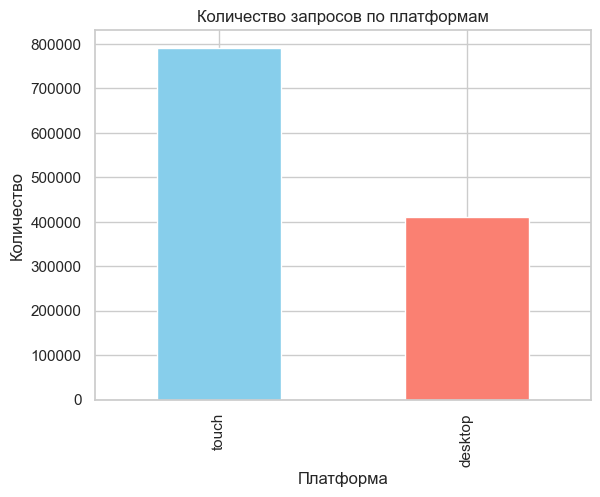

In [26]:
platform_counts = df['platform'].value_counts()
platform_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Количество запросов по платформам')
plt.xlabel('Платформа')
plt.ylabel('Количество')
plt.show()

## 6.2 Количество и распределение уникальных запросов

Количество уникальных запросов

In [27]:
print(len(df['query'].unique()))

23999


Распределение уникальных запросов. Посмотрим, насколько разнообразны запросы и есть ли “шум” (очень редкие или уникальные).

In [28]:
# Кол-во уникальных запросов
n_unique = df['query'].nunique()
print(f"Уникальных запросов: {n_unique:,} ({n_unique/len(df):.2%} от всех)")

Уникальных запросов: 23,999 (1.99% от всех)


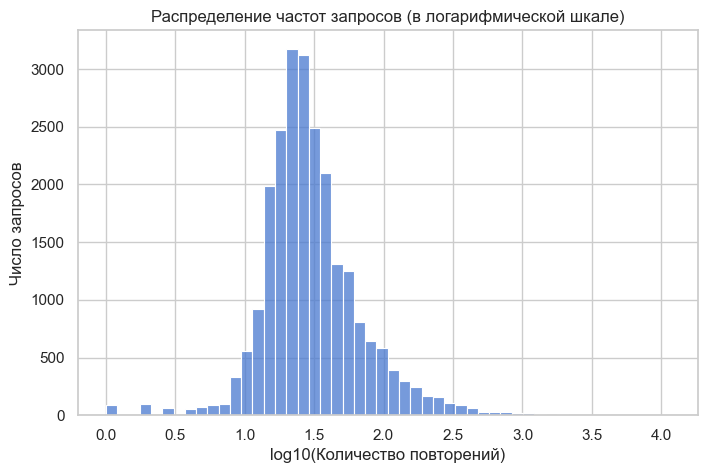

In [29]:
# Распределение частот
query_counts = df['query'].value_counts()
plt.figure(figsize=(8,5))
sns.histplot(np.log10(query_counts.values), bins=50)
plt.title('Распределение частот запросов (в логарифмической шкале)')
plt.xlabel('log10(Количество повторений)')
plt.ylabel('Число запросов')
plt.show()

In [30]:
# Самые редкие (1 раз)
rare = (query_counts == 1).sum()
print(f"Запросов, встречающихся только 1 раз: {rare:,} ({rare/len(query_counts):.2%})")

Запросов, встречающихся только 1 раз: 89 (0.37%)


## 6.3 Наиболее популярные запросы всех пользователей

In [31]:
# Считаем количество вхождений каждого запроса
query_counts = df['query'].value_counts()
query_counts.head(10)

query
порно                     11462
секс                       9193
с днм рождения женщине     5409
календарь 2021             5067
хентай                     5008
таблица менделеева         4932
с днм рождения             4414
с днм рождения мужчине     3994
с днем рождения            3767
картинки                   3519
Name: count, dtype: int64

## 6.4 Топ-10 запросов для каждой платформы

In [32]:
for plat in df['platform'].unique():
    print(f'\nТоп-10 запросов для {plat}:')
    print(df[df['platform'] == plat]['query'].value_counts().head(10))


Топ-10 запросов для touch:
query
порно                     10058
секс                       8248
с днм рождения женщине     4906
хентай                     4187
с днм рождения             4117
с днм рождения мужчине     3662
с днем рождения            3313
xxx                        3247
xnxx                       2763
доброе утро                2338
Name: count, dtype: int64

Топ-10 запросов для desktop:
query
календарь 2021                   2802
таблица менделеева               2656
картинки                         1720
порно                            1404
английский алфавит               1352
одноклассники социальная сеть    1156
обои на рабочий стол             1141
секс                              945
алфавит                           923
таблица квадратов                 883
Name: count, dtype: int64


## 6.5 Топ запросов в сравнении

In [33]:
top_touch = df[df['platform']=='touch']['query'].value_counts().head(10)
top_desktop = df[df['platform']=='desktop']['query'].value_counts().head(10)

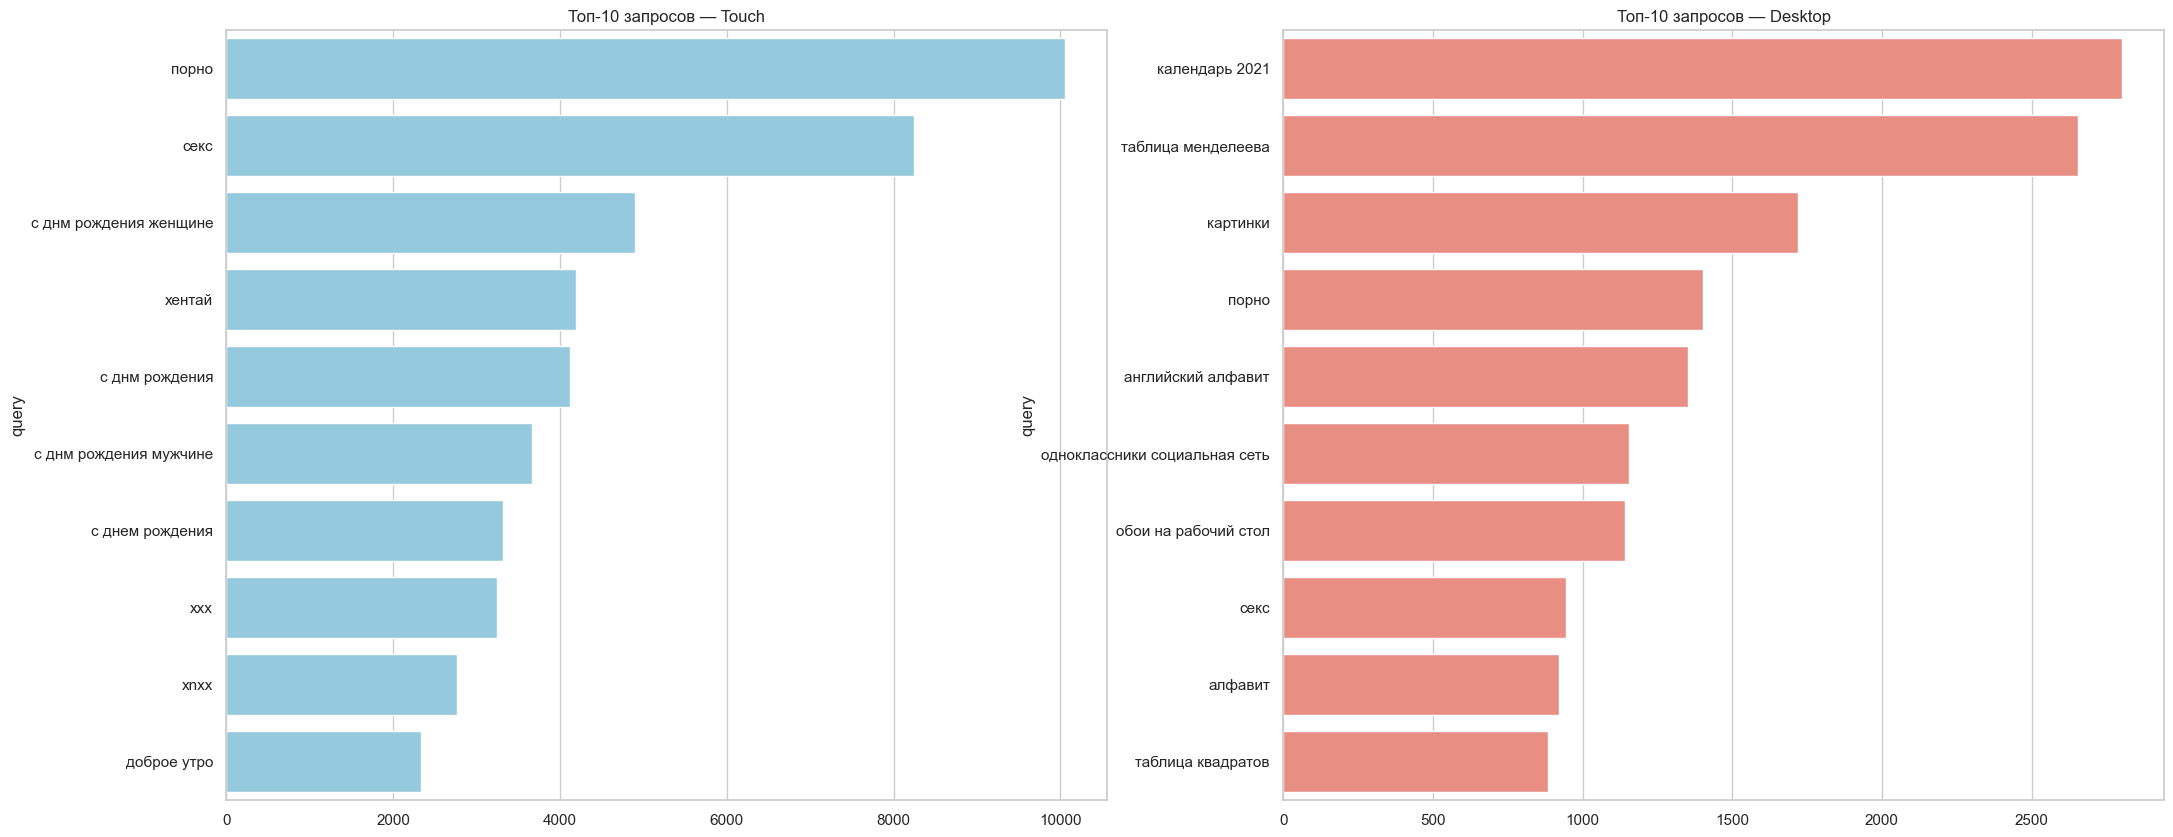

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(25,10))
sns.barplot(y=top_touch.index, x=top_touch.values, ax=axes[0], color='skyblue')
axes[0].set_title('Топ-10 запросов — Touch')

sns.barplot(y=top_desktop.index, x=top_desktop.values, ax=axes[1], color='salmon')
axes[1].set_title('Топ-10 запросов — Desktop')
plt.show()

## 6.5 Анализ длины и структуры запросов

Цель: проверить, отличаются ли пользователи по “стилю” ввода запроса.

In [35]:
df['query_len'] = df['query'].str.split().apply(len)
df['char_len'] = df['query'].str.len()

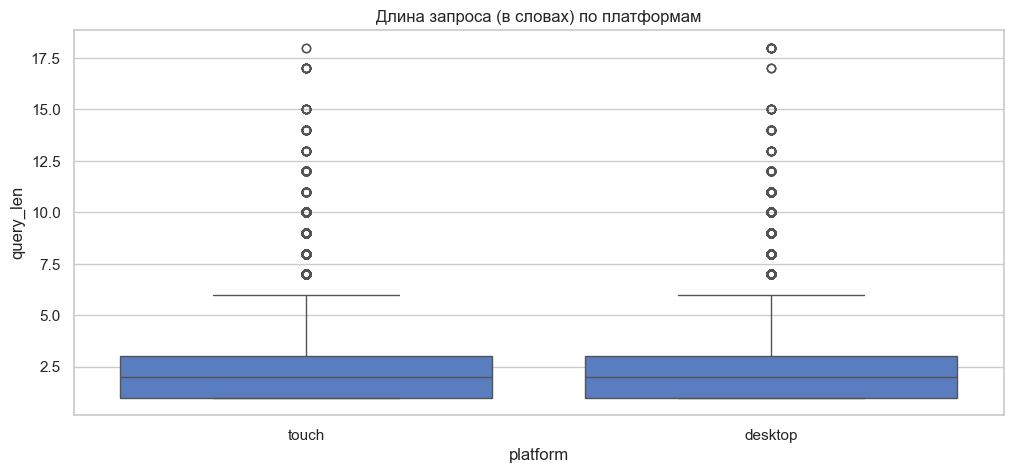

In [36]:
plt.figure(figsize=(12,5))
sns.boxplot(data=df, x='platform', y='query_len')
plt.title('Длина запроса (в словах) по платформам')
plt.show()

In [37]:
print(df.groupby('platform')['query_len'].describe()[['mean','50%','max']])

              mean  50%   max
platform                     
desktop   2.150602  2.0  18.0
touch     2.306826  2.0  18.0


# 7 Анализ временной активности

## 7.1 Динамика активности по датам

In [38]:
df['date'] = df['datetime'].dt.date
daily = df.groupby(['date','platform']).size().reset_index(name='count')

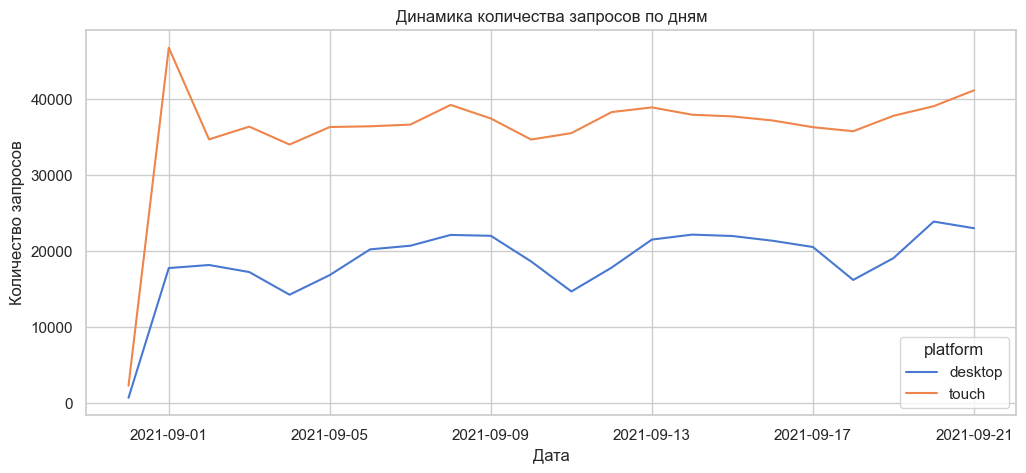

In [39]:
plt.figure(figsize=(12,5))
sns.lineplot(data=daily, x='date', y='count', hue='platform')
plt.title('Динамика количества запросов по дням')
plt.xlabel('Дата')
plt.ylabel('Количество запросов')
plt.show()

## 7.2 Распределение запросов по часам

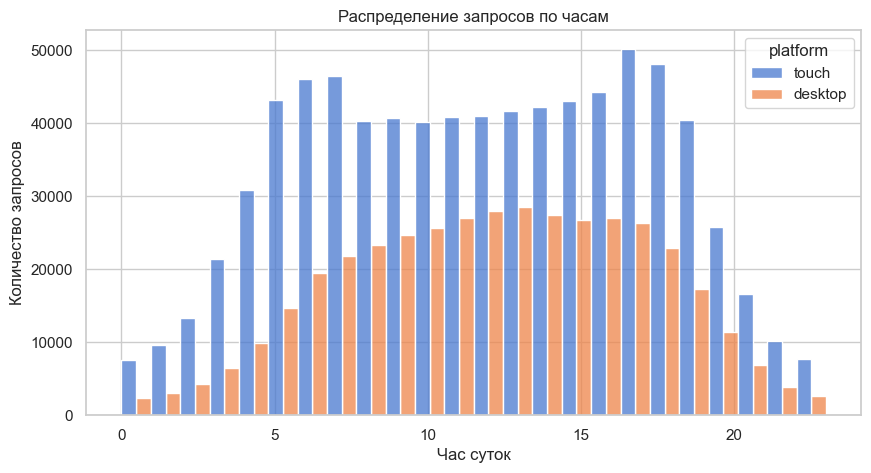

In [40]:
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='hour', hue='platform', multiple='dodge', bins=24)
plt.title('Распределение запросов по часам')
plt.xlabel('Час суток')
plt.ylabel('Количество запросов')
plt.show()

## 7.3 Активность пользователей по дням недели

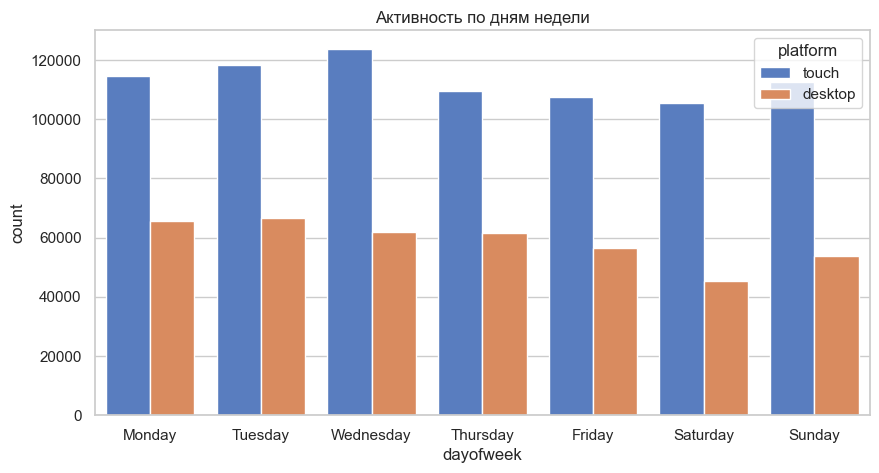

In [41]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='dayofweek', hue='platform', order=[
    'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title('Активность по дням недели')
plt.show()

## 7.4 Тепловая карта день × час

In [42]:
heat = df.groupby(['platform', 'dayofweek', 'hour']).size().reset_index(name='count')
pivot = heat.pivot_table(index='dayofweek', columns='hour', values='count', fill_value=0)

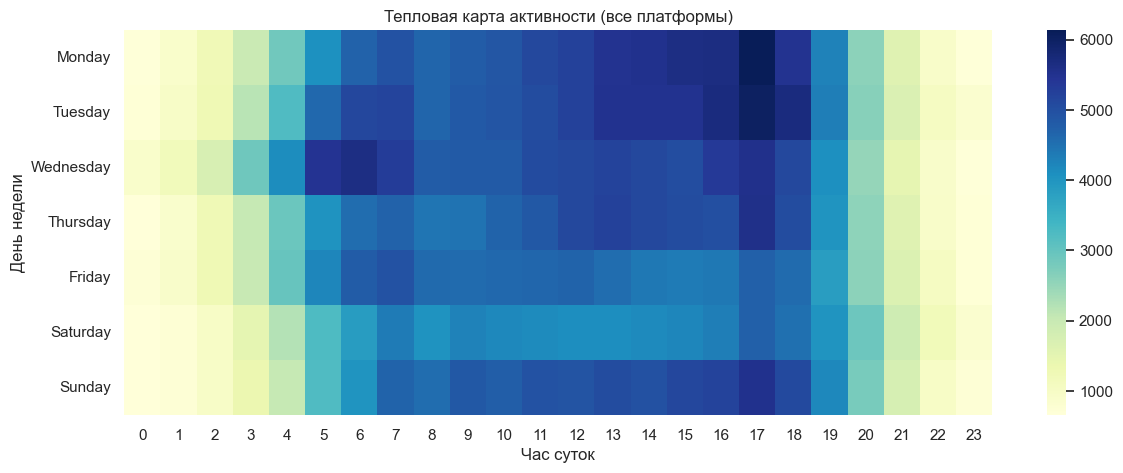

In [43]:
plt.figure(figsize=(14,5))
sns.heatmap(pivot.loc[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']], cmap='YlGnBu')
plt.title('Тепловая карта активности (все платформы)')
plt.xlabel('Час суток')
plt.ylabel('День недели')
plt.show()

## 7.5 Анализ "временных паттернов" (heatmap по платформам отдельно)

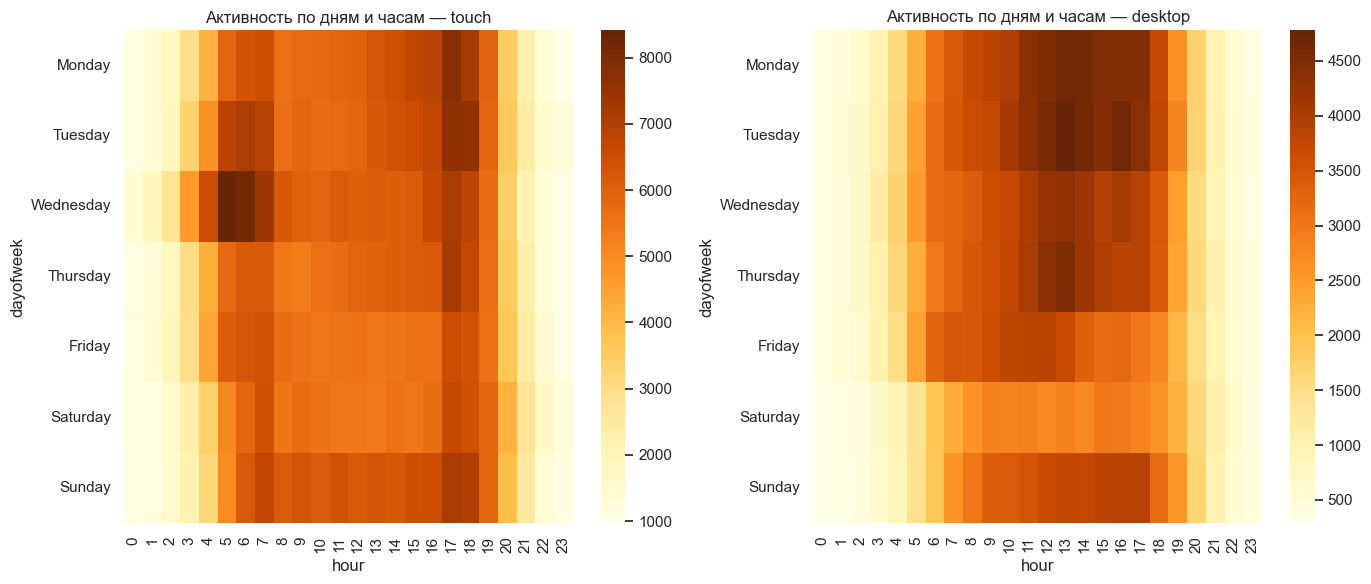

In [44]:
plt.figure(figsize=(14,6))
for i, plat in enumerate(df['platform'].unique()):
    pivot = df[df['platform']==plat].pivot_table(index='dayofweek', columns='hour', values='query', aggfunc='count', fill_value=0)
    plt.subplot(1,2,i+1)
    sns.heatmap(pivot.loc[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']], cmap='YlOrBr')
    plt.title(f'Активность по дням и часам — {plat}')
plt.tight_layout()
plt.show()

# 8 Анализ текстов

## 8.1 TF-IDF-анализ различий

Проанализируем текстовые поисковые запросы пользователей в зависимости от используемого устройства (мобильная версия **«touch»** против компьютера **«desktop»**).

**Зачем это нужно?**

Делается это для того, чтобы выявить различия в интересах и поведении пользователей. Сравнивая важность слов для разных платформ, аналитик может понять, что именно ищут люди «на ходу» (с телефона), а какие задачи предпочитают решать за компьютером. Это помогает в оптимизации контента, рекламы и интерфейса под конкретные устройства.

**Как это работает?**
1. Подготовка (Векторизация): С помощью инструмента **TfidfVectorizer** текст превращается в числа. Параметр **max_features=1000** ограничивает словарь самыми важными словами, а **stop_words** отсеивает «шум» (предлоги, союзы), чтобы они не искажали результат.
2. Расчет **TF-IDF**: Код вычисляет веса слов для двух групп: мобильных **(touch)** и десктопных пользователей. Вес **TF-IDF** показывает, насколько слово уникально и значимо для конкретного набора текстов.
3. Сравнение:
    - Считаются средние веса для каждого слова на обеих платформах.
    - Создается таблица **(DataFrame)**, где вычисляется разница **(diff)** между весами.
4. Результат:
    - Положительная разница подсвечивает слова, характерные для **touch**.
    - Отрицательная разница (при сортировке по возрастанию) подсвечивает слова, характерные для **desktop**.

In [45]:
# Подготовка стоп-слов
nltk.download('stopwords', quiet=True)
russian_stopwords = stopwords.words('russian')

In [46]:
# Инициализация векторизатора
# max_features=1000 оставит только топ-1000 самых частых слов во всем корпусе
vectorizer = TfidfVectorizer(max_features=1000, stop_words=russian_stopwords)

In [47]:
# ОБУЧЕНИЕ (fit) на всех данных, чтобы словарь был общим для обеих платформ
vectorizer.fit(df['query'])

TfidfVectorizer(max_features=1000,
                stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с',
                            'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его',
                            'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы',
                            'по', 'только', 'ее', 'мне', ...])

In [48]:
# ТРАНСФОРМАЦИЯ (transform) отдельно для каждой группы
# Используем .transform(), чтобы использовать уже готовый словарь и веса IDF
tfidf_touch = vectorizer.transform(df[df['platform'] == 'touch']['query'])
tfidf_desktop = vectorizer.transform(df[df['platform'] == 'desktop']['query'])

In [49]:
# Расчет средних весов
touch_mean = np.array(tfidf_touch.mean(axis=0)).flatten()
desktop_mean = np.array(tfidf_desktop.mean(axis=0)).flatten()
terms = vectorizer.get_feature_names_out()

In [50]:
# Сравнение в DataFrame
tfidf_df = pd.DataFrame({
    'term': terms,
    'touch': touch_mean,
    'desktop': desktop_mean
})

In [51]:
tfidf_df['diff'] = tfidf_df['touch'] - tfidf_df['desktop']

In [52]:
# Вывод результатов
print('\nТоп-10 слов, более характерных для TOUCH (мобильных):')
display(tfidf_df.sort_values('diff', ascending=False).head(10))


Топ-10 слов, более характерных для TOUCH (мобильных):


,term,touch,desktop,diff
727,рождения,0.034132,0.006552,0.027580
259,днм,0.029875,0.004995,0.024880
650,порно,0.024781,0.007080,0.017701
765,секс,0.017868,0.003962,0.013907
257,днем,0.013815,0.003417,0.010398
769,сентября,0.013461,0.004684,0.008777
301,женщине,0.011502,0.002842,0.008660
263,доброе,0.007871,0.000881,0.006990
906,утро,0.008054,0.001185,0.006869
527,мужчине,0.008226,0.001610,0.006615


In [53]:
print('\nТоп-10 слов, более характерных для DESKTOP (компьютеров):')
display(tfidf_df.sort_values('diff', ascending=True).head(10))


Топ-10 слов, более характерных для DESKTOP (компьютеров):


,term,touch,desktop,diff
859,таблица,0.005201,0.013496,-0.008296
352,календарь,0.005428,0.013474,-0.008046
707,раскраска,0.000376,0.008258,-0.007882
708,раскраски,0.000257,0.006857,-0.006601
922,фон,0.003290,0.009378,-0.006089
839,стол,0.000772,0.006288,-0.005516
699,рабочий,0.000334,0.005837,-0.005504
97,алфавит,0.006015,0.009670,-0.003655
494,менделеева,0.002413,0.005833,-0.003419
733,россии,0.003704,0.006960,-0.003256


In [54]:
# Подготовка данных: берем топ-10 для touch и топ-10 для desktop
top_touch = tfidf_df.sort_values('diff', ascending=False).head(10)
top_desktop = tfidf_df.sort_values('diff', ascending=True).head(10)
plot_df = pd.concat([top_touch, top_desktop]).sort_values('diff')

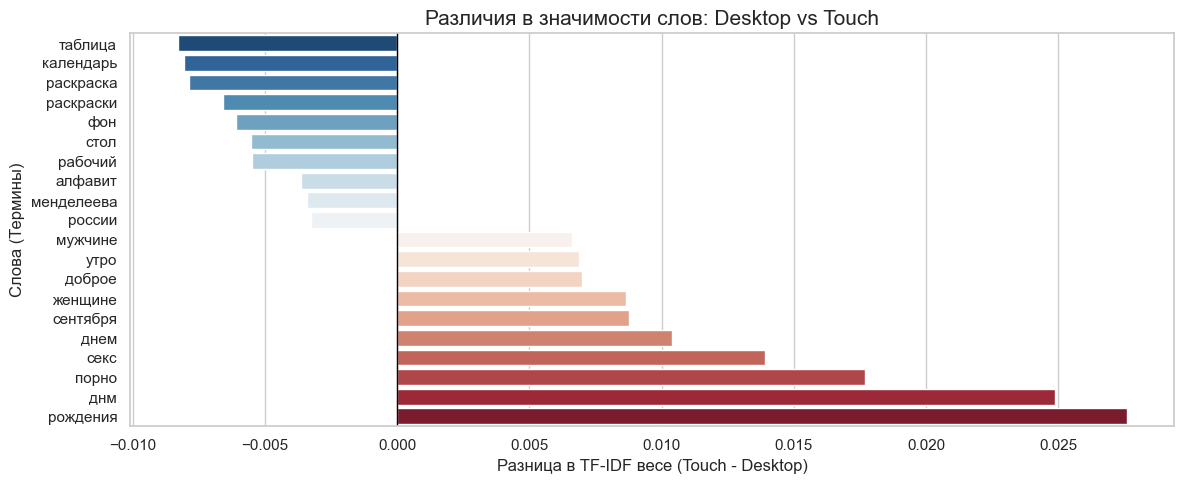

In [55]:
# Настройка стиля
plt.figure(figsize=(12, 5))
# sns.set_theme(style="whitegrid")

# Создание графика
ax = sns.barplot(
    data=plot_df, 
    x='diff', 
    y='term', 
    palette='RdBu_r', # Красно-синяя палитра для контраста
    hue='term',
    legend=False
)

plt.title('Различия в значимости слов: Desktop vs Touch', fontsize=15)
plt.xlabel('Разница в TF-IDF весе (Touch - Desktop)', fontsize=12)
plt.ylabel('Слова (Термины)', fontsize=12)
plt.axvline(0, color='black', lw=1) # Линия разделения на нуле

plt.tight_layout()
plt.show()

## 8.2 Частотный анализ частей речи

Цель: понять, больше ли существительных, прилагательных и т. д.
Это намекает на намерение пользователя (описание объекта или действия).

In [56]:
morph = pymorphy2.MorphAnalyzer()

In [57]:
# Берем подвыборку, чтобы не тормозило
sample = df.sample(50000, random_state=42)
sample['pos'] = sample['query'].apply(
    lambda x: [morph.parse(w)[0].tag.POS for w in x.split() if morph.parse(w)]
)

In [58]:
pos_touch = Counter([p for lst in sample[sample['platform']=='touch']['pos'] for p in lst if p])
pos_desktop = Counter([p for lst in sample[sample['platform']=='desktop']['pos'] for p in lst if p])

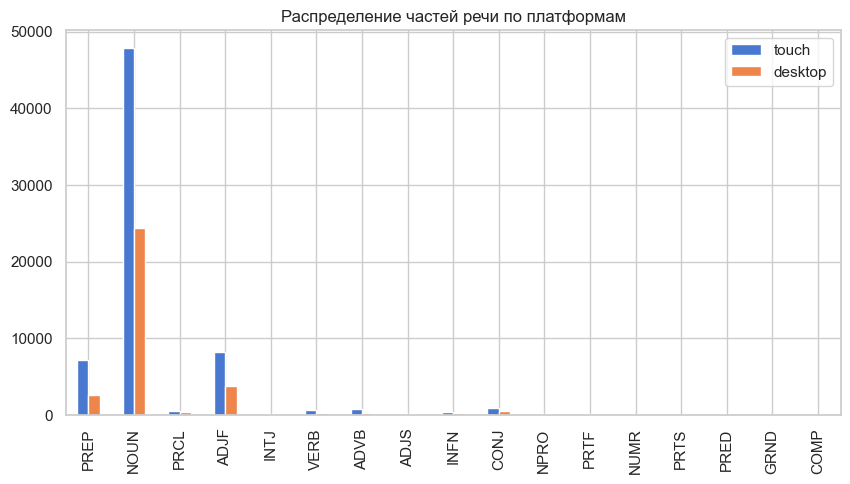

In [59]:
pos_df = pd.DataFrame([pos_touch, pos_desktop]).T.fillna(0)
pos_df.columns = ['touch','desktop']
pos_df.plot(kind='bar', figsize=(10,5))
plt.title('Распределение частей речи по платформам')
plt.show()

## 8.3 Анализ “контрастных слов” (разница частот между платформами)

In [60]:
# Простая токенизация
def tokenize(series):
    return [word for text in series for word in text.split()]

In [61]:
words_touch = Counter(tokenize(df[df['platform']=='touch']['query']))
words_desktop = Counter(tokenize(df[df['platform']=='desktop']['query']))

In [62]:
# Частоты
touch_df = pd.DataFrame(words_touch.items(), columns=['word','touch'])
desktop_df = pd.DataFrame(words_desktop.items(), columns=['word','desktop'])
merged = pd.merge(touch_df, desktop_df, on='word', how='outer').fillna(0)
merged['ratio'] = (merged['touch'] + 1) / (merged['desktop'] + 1)
merged = merged[(merged['touch']+merged['desktop']) > 50]  # отсекаем редкие слова

In [63]:
# Сильнее всего отличаются
display(merged.sort_values('ratio', ascending=False).head(10))
display(merged.sort_values('ratio', ascending=True).head(10))

,word,touch,desktop,ratio
395,colmek,399.0,1.0,200.000000
227,apetube,188.0,0.0,189.000000
786,korea,159.0,0.0,160.000000
10988,привлекательности,148.0,0.0,149.000000
704,indo,418.0,2.0,139.666667
992,pap,138.0,0.0,139.000000
1291,tetek,132.0,0.0,133.000000
785,kontol,445.0,3.0,111.500000
1039,pokerdom,105.0,0.0,106.000000
1331,tt,103.0,0.0,104.000000


,word,touch,desktop,ratio
15918,яндекспочта,0.0,178.0,0.005587
14192,услуг,2.0,480.0,0.006237
4151,государственных,2.0,480.0,0.006237
696,iii,0.0,94.0,0.010526
904,modern,0.0,89.0,0.011111
1390,warfare,0.0,89.0,0.011111
977,online,0.0,87.0,0.011364
1245,stalker,0.0,82.0,0.012048
971,offensive,0.0,79.0,0.012500
620,global,0.0,79.0,0.012500


## 8.4 PCA / t-SNE визуализация запросов (для анализа тем)

Цель: увидеть кластеры запросов и “темы”.

In [64]:
# Берем готовые русские стоп-слова
russian_stopwords = stopwords.words('russian')

In [65]:
# Создаем векторизатор — теперь корректно
vectorizer = TfidfVectorizer(max_features=500, stop_words=russian_stopwords)

In [66]:
# Преобразуем тексты
X = vectorizer.fit_transform(sample['query'])

In [67]:
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X.toarray())

In [68]:
sample['x'] = coords[:,0]
sample['y'] = coords[:,1]

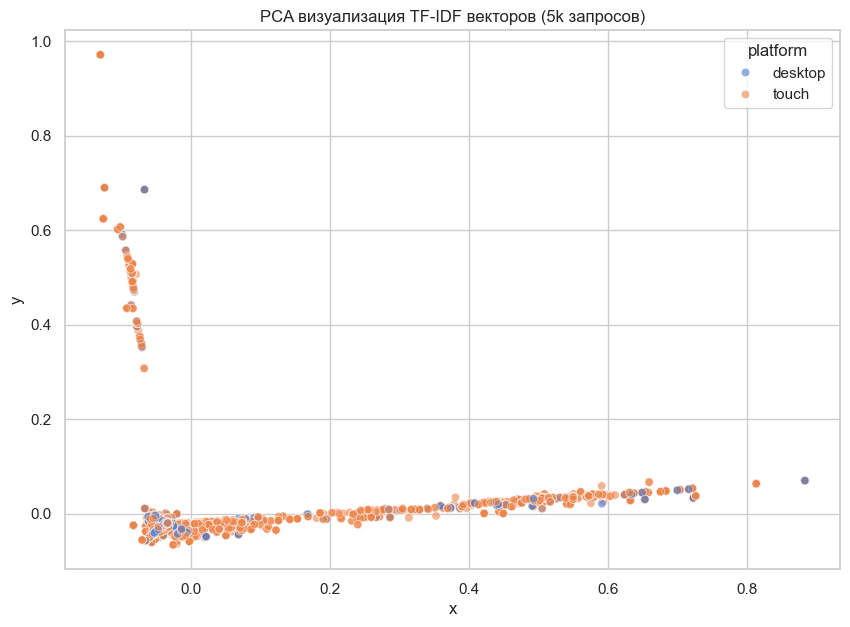

In [69]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=sample, x='x', y='y', hue='platform', alpha=0.6)
plt.title('PCA визуализация TF-IDF векторов (5k запросов)')
plt.show()

## 8.5 Словари и биграммы (анализ сочетаний слов)

Цель: выделить часто встречающиеся пары слов (“малевич картина”, “фон телефон”).

In [70]:
# создаем векторизатор для биграмм
vectorizer = CountVectorizer(stop_words=russian_stopwords, ngram_range=(2, 2))

In [71]:
for plat in df['platform'].unique():
    X = vectorizer.fit_transform(df[df['platform'] == plat]['query'])
    bigrams = pd.Series(np.array(X.sum(axis=0)).flatten(), index=vectorizer.get_feature_names_out())
    print(f"\nТоп-10 биграмм для {plat}:")
    print(bigrams.sort_values(ascending=False).head(10))


Топ-10 биграмм для touch:
днм рождения        43875
рождения женщине    15698
днем рождения       11437
рождения мужчине    10135
доброе утро          9717
добрым утром         6144
поздравления днм     6125
метро москвы         4915
карта метро          4747
открытки днм         4579
dtype: int64

Топ-10 биграмм для desktop:
рабочий стол             4507
днм рождения             4139
календарь 2021           4081
таблица менделеева       3291
календарь 2022           2756
обои рабочий             2729
рождения женщине         2111
праздниками выходными    1843
английский алфавит       1741
карта мира               1592
dtype: int64


## 8.6 Облако слов

Посмотрим на облака слов по платформам, чтобы увидеть разницу в поведении пользователей. **Чем крупнее слова, тем наиболее часто оно встречается в запросе**. Цвет не имеет значения.

Что в этом цикле:
- Цикл по платформам: Код находит все уникальные платформы в df['platform'] и запускает процесс для каждой;
- Сбор текста: Все запросы одной платформы склеиваются в одну длинную строку;
- Генерация облака: Библиотека WordCloud считает частоту слов. Чем чаще слово встречается в запросах, тем крупнее оно будет на картинке;
- Отрисовка: matplotlib рисует график, скрывает оси координат (axis('off')) и добавляет заголовок с названием платформы.


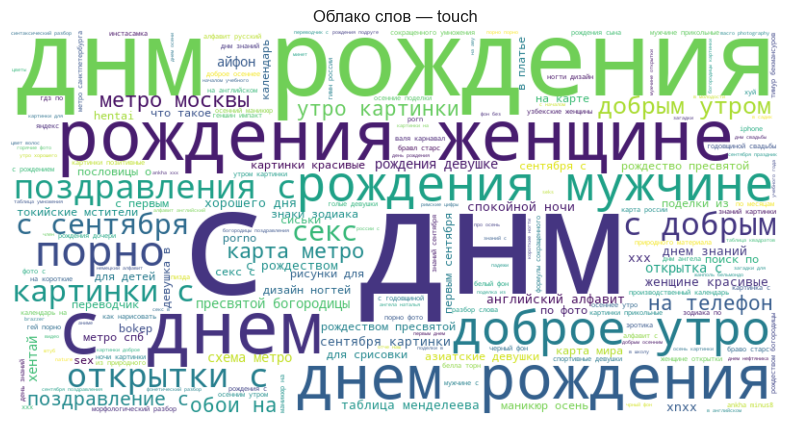

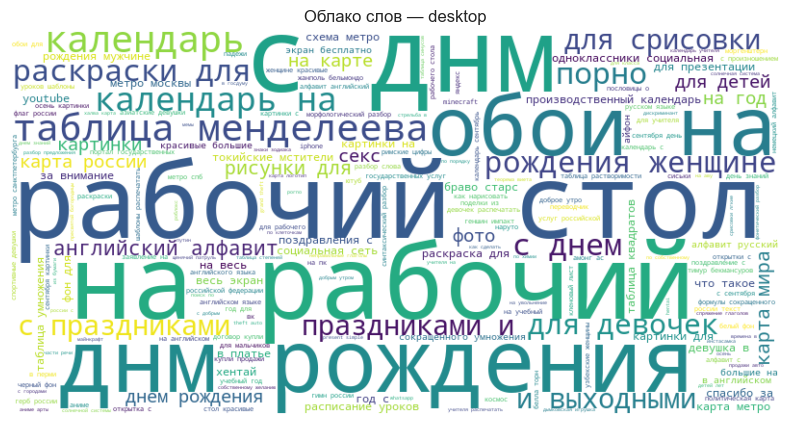

In [72]:
for plat in df['platform'].unique():
    text = ' '.join(df[df['platform'] == plat]['query'])
    wc = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Облако слов — {plat}')
    plt.show()